In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, average_precision_score
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import pandas as pd
import model_get
import pickle as pkl

In [2]:
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve

physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], False)

def loadGlove(inputpath, outputpath=""):
    data_list = []
    wordEmb = {}
    with open(inputpath) as f:
        for line in f:
            ll = line.strip().split(',')
            ll[0] = str(int(float(ll[0])))
            data_list.append(ll)

            ll_new = [float(i) for i in ll]
            emb = np.array(ll_new[1:], dtype="float32")
            wordEmb[str(int(ll_new[0]))] = emb

    if outputpath != "":
        with open(outputpath) as f:
            for data in data_list:
                f.writelines(' '.join(data))
    return wordEmb


def plotPrecisionRecallCurve(estimators, labels, xtests, ytests, flnm, icol=1):
    colors = sns.color_palette("husl", len(estimators))  # Use a color palette from seaborn
    indx = 0
    plt.figure(figsize=(10, 6))  # Increase figure size
    plt.plot([0, 1], [0, 1], 'k--')
    for estimator, color in zip(estimators, colors):
        if len(ytests[indx].shape) == 2:
            pre, rec, _ = precision_recall_curve(ytests[indx][:, icol], estimator.predict(xtests[indx])[:, icol], pos_label=icol)
        else:
            pre, rec, _ = precision_recall_curve(ytests[indx], estimator.predict_proba(xtests[indx])[:, icol], pos_label=icol)
        plt.plot(rec, pre, label=labels[indx] + ' (PR AUC: %s \u00B1 0.001)' % (np.round(auc(rec, pre), 3)), color=color)
        indx += 1
    plt.xlabel('Recall', fontsize=14)  # Increase font size
    plt.ylabel('Precision', fontsize=14)  # Increase font size
    plt.legend(loc='best', fontsize=12)  # Increase font size
    plt.savefig(flnm)


def plotRocCurve(estimators, labels, xtests, ytests, flnm, icol=1):
    colors = sns.color_palette("husl", len(estimators))  # Use a color palette from seaborn
    indx = 0
    plt.figure(figsize=(10, 6))  # Increase figure size
    plt.plot([0, 1], [0, 1], 'k--')
    for estimator, color in zip(estimators, colors):
        if len(ytests[indx].shape) == 2:
            fprs, tprs, _ = roc_curve(ytests[indx][:, icol], estimator.predict(xtests[indx])[:, icol])
        else:
            fprs, tprs, _ = roc_curve(ytests[indx], estimator.predict_proba(xtests[indx])[:, icol])
        plt.plot(fprs, tprs, label=labels[indx] + ' (ROC AUC: %s \u00B1 0.001)' % (np.round(auc(fprs, tprs), 3)), color=color)
        indx += 1
    plt.xlabel('False positive rate', fontsize=14)  # Increase font size
    plt.ylabel('True positive rate', fontsize=14)  # Increase font size
    plt.legend(loc='best', fontsize=12)  # Increase font size
    plt.savefig(flnm)    
        

In [3]:
import random
import os
seed = 123
random.seed(seed)
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)


def f1_metric(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    return f1_val


early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_f1_metric', min_delta=0.0001,
    patience=10, verbose=0, mode='max')
callbacks = [early_stopping]

dataset = 'hek293t'
num_classes = 2
flpath = 'data/'


retrain = False

# cross-validation

Crispr_IP

In [4]:
# Initialize the cross-validation splitter
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

print('crispr_ip_model')
encoder_shape = (23, 6)
seg_len, coding_dim = encoder_shape

open_name = 'encoded6x23' + dataset + '.pkl'


print('load data!')
print(open_name)

loaddata = pkl.load(
    open(flpath + open_name, 'rb'),
    encoding='latin1'
)

# Prepare data for cross-validation
X = np.array(loaddata.images)
y = loaddata.target

eval_fun_names = ['Accuracy', 'F1 score', 'Precision', 'Recall', 'ROC AUC', 'PR AUC']
eval_funs = [accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, average_precision_score]
eval_fun_types = [True, True, True, True, False, False]

# Initialize the result dict
results1 = {name: [] for name in eval_fun_names}

# Load the pre-trained model
model_path = 'saved_model/'+dataset+'crispr_ip.h5'
crispr_ip_model = load_model(model_path, custom_objects={'f1_metric': f1_metric})

# Perform cross-validation
for train_index, test_index in cv.split(X, y):
    X_train_full, X_test = X[train_index], X[test_index]
    y_train_full, y_test = y[train_index], y[test_index]

    # Create a validation set from the full training data
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_full,
        y_train_full,
        stratify=pd.Series(y_train_full),
        test_size=0.2,
        shuffle=True,
        random_state=42)

    # Transform the data
    X_train, X_test1, y_train, y_test1, X_val, y_val, input_shape = model_get.transformIO(
        X_train, X_test, y_train, y_test, X_val, y_val, seg_len, coding_dim, num_classes
    )
    # Calculate metrics
    y_score = crispr_ip_model.predict(X_test1)
    y_pred = np.argmax(y_score, axis=1)
    y_score = y_score[:, 1]
    y_test = np.argmax(y_test1, axis=1)

    # Store the metrics
    for index_f, function in enumerate(eval_funs):
        if eval_fun_types[index_f]:
            score = np.round(function(y_test, y_pred), 4)
        else:
            score = np.round(function(y_test, y_score), 4)
        results1[eval_fun_names[index_f]].append(score)

# Calculate the average of metrics
avg_results1 = {name: np.mean(scores) for name, scores in results1.items()}

# Print the average metrics
for name, avg_score in avg_results1.items():
    print('{:<15}{:>15}'.format(name, avg_score))

crispr_ip_model
load data!
encoded6x23hek293t.pkl
xtrain shape: (36636, 1, 23, 6)
36636 train samples
11449 test samples
9160 val samples
xtrain shape: (36636, 1, 23, 6)
36636 train samples
11449 test samples
9160 val samples
xtrain shape: (36636, 1, 23, 6)
36636 train samples
11449 test samples
9160 val samples
xtrain shape: (36636, 1, 23, 6)
36636 train samples
11449 test samples
9160 val samples
xtrain shape: (36636, 1, 23, 6)
36636 train samples
11449 test samples
9160 val samples
Accuracy                0.7943
F1 score       0.016360000000000003
Precision      0.008560000000000002
Recall                  0.1903
ROC AUC                0.51006
PR AUC         0.009720000000000001


cnn_std

In [15]:
# Initialize the cross-validation splitter
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

print('cnn_std')
encoder_shape = (23, 4)
seg_len, coding_dim = encoder_shape

open_name = 'encoded4x23' + dataset + '.pkl'


print('load data!')
print(open_name)

loaddata = pkl.load(
    open(flpath + open_name, 'rb'),
    encoding='latin1'
)

# Prepare data for cross-validation
X = np.array(loaddata.images)
y = loaddata.target

eval_fun_names = ['Accuracy', 'F1 score', 'Precision', 'Recall', 'ROC AUC', 'PR AUC']
eval_funs = [accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, average_precision_score]
eval_fun_types = [True, True, True, True, False, False]

# Initialize the result dict
results2 = {name: [] for name in eval_fun_names}

# Load the pre-trained model
model_path = 'saved_model/'+dataset+'cnn_std.h5'
cnn_std_model = load_model(model_path,custom_objects={'f1_metric': f1_metric})

# Perform cross-validation
for train_index, test_index in cv.split(X, y):
    X_train_full, X_test = X[train_index], X[test_index]
    y_train_full, y_test = y[train_index], y[test_index]

    # Create a validation set from the full training data
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_full,
        y_train_full,
        stratify=pd.Series(y_train_full),
        test_size=0.2,
        shuffle=True,
        random_state=42)

    # Transform the data
    X_train, X_test2, y_train, y_test2, X_val, y_val, input_shape = model_get.cnn_std_transformIO(
        X_train, X_test, y_train, y_test, X_val, y_val, seg_len, coding_dim, num_classes
    )
    # Calculate metrics
    y_score = cnn_std_model.predict(X_test2)
    y_pred = np.argmax(y_score, axis=1)
    y_score = y_score[:, 1]
    y_test = np.argmax(y_test2, axis=1)

    # Store the metrics
    for index_f, function in enumerate(eval_funs):
        if eval_fun_types[index_f]:
            score = np.round(function(y_test, y_pred), 4)
        else:
            score = np.round(function(y_test, y_score), 4)
        results2[eval_fun_names[index_f]].append(score)

# Calculate the average of metrics
avg_results2 = {name: np.mean(scores) for name, scores in results2.items()}

# Print the average metrics
for name, avg_score in avg_results2.items():
    print('{:<15}{:>15}'.format(name, avg_score))

cnn_std
load data!
encoded4x23hek293t.pkl
xtrain shape: (36636, 1, 23, 4)
36636 train samples
11449 test samples
9160 xval samples
xtrain shape: (36636, 1, 23, 4)
36636 train samples
11449 test samples
9160 xval samples
xtrain shape: (36636, 1, 23, 4)
36636 train samples
11449 test samples
9160 xval samples
xtrain shape: (36636, 1, 23, 4)
36636 train samples
11449 test samples
9160 xval samples
xtrain shape: (36636, 1, 23, 4)
36636 train samples
11449 test samples
9160 xval samples
Accuracy       0.44645999999999997
F1 score               0.01666
Precision              0.00848
Recall         0.5184399999999999
ROC AUC        0.48389999999999994
PR AUC                 0.00878


crisprDNT

In [8]:
from model_get import PositionalEncoding
from keras_multi_head import MultiHeadAttention

# Initialize the cross-validation splitter
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

print('crisprDNT')
encoder_shape = (23, 14)
seg_len, coding_dim = encoder_shape

open_name = 'encodedmismatchtype14x23' + dataset + '.pkl'


print('load data!')
print(open_name)

loaddata = pkl.load(
    open(flpath + open_name, 'rb'),
    encoding='latin1'
)

# Prepare data for cross-validation
X = np.array(loaddata.images)
y = loaddata.target

eval_fun_names = ['Accuracy', 'F1 score', 'Precision', 'Recall', 'ROC AUC', 'PR AUC']
eval_funs = [accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, average_precision_score]
eval_fun_types = [True, True, True, True, False, False]

# Initialize the result dict
results3 = {name: [] for name in eval_fun_names}

# Load the pre-trained model
model_path = 'saved_model/'+dataset+'crisprDNT.h5'
crisprDNT = load_model(model_path, custom_objects={'PositionalEncoding': PositionalEncoding,'MultiHeadAttention':MultiHeadAttention,'f1_metric': f1_metric})

# Perform cross-validation
for train_index, test_index in cv.split(X, y):
    X_train_full, X_test = X[train_index], X[test_index]
    y_train_full, y_test = y[train_index], y[test_index]

    # Create a validation set from the full training data
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_full,
        y_train_full,
        stratify=pd.Series(y_train_full),
        test_size=0.2,
        shuffle=True,
        random_state=42)

    # Transform the data
    X_train, X_test3, y_train, y_test3, X_val, y_val, input_shape = model_get.transformIO(
        X_train, X_test, y_train, y_test, X_val, y_val, seg_len, coding_dim, num_classes
    )
    # Calculate metrics
    y_score = crisprDNT.predict(X_test3)
    y_pred = np.argmax(y_score, axis=1)
    y_score = y_score[:, 1]
    y_test = np.argmax(y_test3, axis=1)

    # Store the metrics
    for index_f, function in enumerate(eval_funs):
        if eval_fun_types[index_f]:
            score = np.round(function(y_test, y_pred), 4)
        else:
            score = np.round(function(y_test, y_score), 4)
        results3[eval_fun_names[index_f]].append(score)

# Calculate the average of metrics
avg_results3 = {name: np.mean(scores) for name, scores in results3.items()}

# Print the average metrics
for name, avg_score in avg_results3.items():
    print('{:<15}{:>15}'.format(name, avg_score))

crisprDNT
load data!
encodedmismatchtype14x23hek293t.pkl
xtrain shape: (36636, 1, 23, 14)
36636 train samples
11449 test samples
9160 val samples
xtrain shape: (36636, 1, 23, 14)
36636 train samples
11449 test samples
9160 val samples
xtrain shape: (36636, 1, 23, 14)
36636 train samples
11449 test samples
9160 val samples
xtrain shape: (36636, 1, 23, 14)
36636 train samples
11449 test samples
9160 val samples
xtrain shape: (36636, 1, 23, 14)
36636 train samples
11449 test samples
9160 val samples
Accuracy               0.99756
F1 score               0.85416
Precision      0.9122399999999999
Recall                 0.80388
ROC AUC        0.9942599999999999
PR AUC         0.8993800000000001


crisprNet

In [9]:
# Initialize the cross-validation splitter
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

print('CRISPR_Net')
encoder_shape = (23, 7)
seg_len, coding_dim = encoder_shape

open_name = 'encoded7x23' + dataset + '.pkl'


print('load data!')
print(open_name)

loaddata = pkl.load(
    open(flpath + open_name, 'rb'),
    encoding='latin1'
)

# Prepare data for cross-validation
X = np.array(loaddata.images)
y = loaddata.target

eval_fun_names = ['Accuracy', 'F1 score', 'Precision', 'Recall', 'ROC AUC', 'PR AUC']
eval_funs = [accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, average_precision_score]
eval_fun_types = [True, True, True, True, False, False]

# Initialize the result dict
results4 = {name: [] for name in eval_fun_names}

# Load the pre-trained model
model_path = 'saved_model/'+dataset+'CRISPR_Net.h5'
CRISPR_Net_model = load_model(model_path, custom_objects={'f1_metric': f1_metric})

# Perform cross-validation
for train_index, test_index in cv.split(X, y):
    X_train_full, X_test = X[train_index], X[test_index]
    y_train_full, y_test = y[train_index], y[test_index]

    # Create a validation set from the full training data
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_full,
        y_train_full,
        stratify=pd.Series(y_train_full),
        test_size=0.2,
        shuffle=True,
        random_state=42)

    # Transform the data
    X_train, X_test4, y_train, y_test4, X_val, y_val, input_shape = model_get.CRISPR_Net_transformIO(
        X_train, X_test, y_train, y_test, X_val, y_val, seg_len, coding_dim, num_classes
    )
    # Calculate metrics
    y_score = CRISPR_Net_model.predict(X_test4)
    y_pred = np.argmax(y_score, axis=1)
    y_score = y_score[:, 1]
    y_test = np.argmax(y_test4, axis=1)

    # Store the metrics
    for index_f, function in enumerate(eval_funs):
        if eval_fun_types[index_f]:
            score = np.round(function(y_test, y_pred), 4)
        else:
            score = np.round(function(y_test, y_score), 4)
        results4[eval_fun_names[index_f]].append(score)

# Calculate the average of metrics
avg_results4 = {name: np.mean(scores) for name, scores in results4.items()}

# Print the average metrics
for name, avg_score in avg_results4.items():
    print('{:<15}{:>15}'.format(name, avg_score))

CRISPR_Net
load data!
encoded7x23hek293t.pkl
xtrain shape: (36636, 1, 23, 7)
36636 train samples
11449 test samples
9160 val samples
xtrain shape: (36636, 1, 23, 7)
36636 train samples
11449 test samples
9160 val samples
xtrain shape: (36636, 1, 23, 7)
36636 train samples
11449 test samples
9160 val samples
xtrain shape: (36636, 1, 23, 7)
36636 train samples
11449 test samples
9160 val samples
xtrain shape: (36636, 1, 23, 7)
36636 train samples
11449 test samples
9160 val samples
Accuracy               0.99726
F1 score       0.8458600000000001
Precision              0.84986
Recall         0.8427200000000001
ROC AUC        0.9942599999999999
PR AUC                 0.89184


cnnCRISPR

In [11]:
# Initialize the cross-validation splitter
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

print('cnn_crispr model')
print("GloVe model loaded")
VOCAB_SIZE = 16  # 4**3
EMBED_SIZE = 100
glove_inputpath = "data/keras_GloVeVec_" + dataset + "_5_100_10000.csv"
# load GloVe model
model_glove = loadGlove(glove_inputpath)
embedding_weights = np.zeros((VOCAB_SIZE, EMBED_SIZE))
for i in range(VOCAB_SIZE):
    embedding_weights[i, :] = model_glove[str(i)]

open_name = 'encoded_CnnCrispr_' + dataset + '.pkl'

print('load data!')
print(open_name)

loaddata = pkl.load(
    open(flpath + open_name, 'rb'),
    encoding='latin1'
)

# Prepare data for cross-validation
X = np.array(loaddata.images)
y = loaddata.target

eval_fun_names = ['Accuracy', 'F1 score', 'Precision', 'Recall', 'ROC AUC', 'PR AUC']
eval_funs = [accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, average_precision_score]
eval_fun_types = [True, True, True, True, False, False]

# Initialize the result dict
results5 = {name: [] for name in eval_fun_names}

# Load the pre-trained model
model_path = 'saved_model/'+dataset+'CnnCrispr.h5'
CnnCrispr_model = load_model(model_path, custom_objects={'f1_metric': f1_metric})

# Perform cross-validation
for train_index, test_index in cv.split(X, y):
    X_train_full, X_test = X[train_index], X[test_index]
    y_train_full, y_test = y[train_index], y[test_index]

    # Create a validation set from the full training data
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_full,
        y_train_full,
        stratify=pd.Series(y_train_full),
        test_size=0.2,
        shuffle=True,
        random_state=42)

    # Transform the data
    X_train, X_test5, y_train, y_test5, X_val, y_val = model_get.offt_transformIO(
        X_train, X_test, y_train, y_test, X_val, y_val, num_classes
    )
    # Calculate metrics
    y_score = CnnCrispr_model.predict(X_test5)
    y_pred = np.argmax(y_score, axis=1)
    y_score = y_score[:, 1]
    y_test = np.argmax(y_test5, axis=1)

    # Store the metrics
    for index_f, function in enumerate(eval_funs):
        if eval_fun_types[index_f]:
            score = np.round(function(y_test, y_pred), 4)
        else:
            score = np.round(function(y_test, y_score), 4)
        results5[eval_fun_names[index_f]].append(score)

# Calculate the average of metrics
avg_results5 = {name: np.mean(scores) for name, scores in results5.items()}

# Print the average metrics
for name, avg_score in avg_results5.items():
    print('{:<15}{:>15}'.format(name, avg_score))

cnn_crispr model
GloVe model loaded
load data!
encoded_CnnCrispr_hek293t.pkl
xtrain shape: (36636, 23)
36636 train samples
11449 test samples
9160 val samples
xtrain shape: (36636, 23)
36636 train samples
11449 test samples
9160 val samples
xtrain shape: (36636, 23)
36636 train samples
11449 test samples
9160 val samples
xtrain shape: (36636, 23)
36636 train samples
11449 test samples
9160 val samples
xtrain shape: (36636, 23)
36636 train samples
11449 test samples
9160 val samples
Accuracy               0.01868
F1 score       0.017779999999999997
Precision              0.00896
Recall         0.9864200000000001
ROC AUC                0.50062
PR AUC         0.009540000000000002


# Plot

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

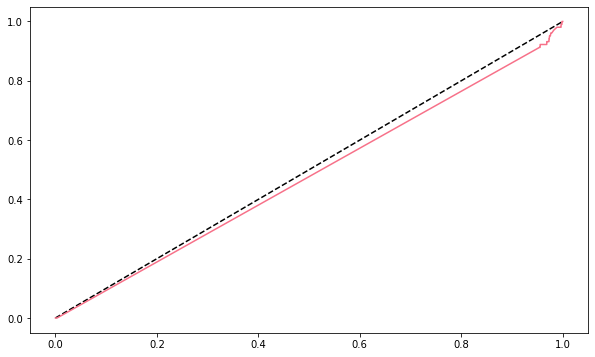

In [16]:
models = [ crispr_ip_model, cnn_std_model, crisprDNT, CRISPR_Net_model, CnnCrispr_model]

labels = ['CRISPR_IP', 'CNN_std', 'CrisprDNT', 'CRISPR_Net', 'CnnCrispr']

xtests = [X_test1, X_test2, X_test3, X_test4, X_test5]

ytests = [y_test1, y_test2, y_test3, y_test4, y_test5]

roc_name = 'fig/ROC_5fold_' + dataset + '.png'
pr_name = 'fig/PR_5fold_' + dataset + '.png'

plotRocCurve(models, labels, xtests, ytests, roc_name)

plotPrecisionRecallCurve(models, labels, xtests, ytests, pr_name)
# models = [ crispr_ip_model, cnn_std_model, crisprDNT, CRISPR_Net_model]

# labels = ['CRISPR_IP', 'CNN_std', 'CrisprDNT', 'CRISPR_Net']

# xtests = [X_test1, X_test2, X_test3, X_test4]

# ytests = [y_test1, y_test2, y_test3, y_test4]

# roc_name = 'fig/ROC_5fold_' + dataset + '.png'
# pr_name = 'fig/PR_5fold_' + dataset + '.png'

# plotRocCurve(models, labels, xtests, ytests, roc_name)

# plotPrecisionRecallCurve(models, labels, xtests, ytests, pr_name)

In [ ]:
def plot_metrics(metrics, labels, filename):
    """
    :param metrics: dict, keys are metric names, values are lists of metric scores for each model
    :param labels: list of str, model names
    :param filename: str, the name of the file where the plot will be saved
    """
    num_metrics = len(metrics.keys())
    fig, axes = plt.subplots(num_metrics, 1, figsize=(10, num_metrics * 5))

    # Create a color palette
    colors = sns.color_palette("husl", len(labels))

    for ax, metric in zip(axes, metrics.keys()):
        ax.bar(labels, metrics[metric], color=colors)
        ax.set_title(metric, fontsize=16)
        ax.set_ylim([0, 1])  # The metrics range from 0 to 1
        ax.set_ylabel(metric, fontsize=14)

    # Save the figure
    plt.tight_layout()
    plt.savefig(filename)

In [ ]:
# # Extract the metrics for each model
# accuracy_scores1 = avg_results1['Accuracy']
# accuracy_scores2 = avg_results2['Accuracy']
# accuracy_scores3 = avg_results3['Accuracy']
# accuracy_scores4 = avg_results4['Accuracy']
# accuracy_scores5 = avg_results5['Accuracy']

# f1_scores1 = avg_results1['F1 score']
# f1_scores2 = avg_results2['F1 score']
# f1_scores3 = avg_results3['F1 score']
# f1_scores4 = avg_results4['F1 score']
# f1_scores5 = avg_results5['F1 score']

# recall_scores1 = avg_results1['Recall']
# recall_scores2 = avg_results2['Recall']
# recall_scores3 = avg_results3['Recall']
# recall_scores4 = avg_results4['Recall']
# recall_scores5 = avg_results5['Recall']

# # Create dictionaries for each metric that contains the scores for all models
# accuracy_scores = [accuracy_scores1, accuracy_scores2, accuracy_scores3, accuracy_scores4, accuracy_scores5]
# f1_scores = [f1_scores1, f1_scores2, f1_scores3, f1_scores4, f1_scores5]
# recall_scores = [recall_scores1, recall_scores2, recall_scores3, recall_scores4, recall_scores5]

# metrics = {
#     'Accuracy': accuracy_scores,
#     'F1 score': f1_scores,
#     'Recall': recall_scores
# }


# labels = ['CRISPR_IP', 'CNN_std', 'CrisprDNT', 'CRISPR_Net', 'CnnCrispr']

# plot_metrics(metrics, labels, 'fig/5-fold_metrics_plot.png')
# Extract the metrics for each model
accuracy_scores1 = avg_results1['Accuracy']
accuracy_scores2 = avg_results2['Accuracy']
accuracy_scores3 = avg_results3['Accuracy']
accuracy_scores4 = avg_results4['Accuracy']


f1_scores1 = avg_results1['F1 score']
f1_scores2 = avg_results2['F1 score']
f1_scores3 = avg_results3['F1 score']
f1_scores4 = avg_results4['F1 score']


recall_scores1 = avg_results1['Recall']
recall_scores2 = avg_results2['Recall']
recall_scores3 = avg_results3['Recall']
recall_scores4 = avg_results4['Recall']


# Create dictionaries for each metric that contains the scores for all models
accuracy_scores = [accuracy_scores1, accuracy_scores2, accuracy_scores3, accuracy_scores4]
f1_scores = [f1_scores1, f1_scores2, f1_scores3, f1_scores4]
recall_scores = [recall_scores1, recall_scores2, recall_scores3, recall_scores4]

metrics = {
    'Accuracy': accuracy_scores,
    'F1 score': f1_scores,
    'Recall': recall_scores
}


labels = ['CRISPR_IP', 'CNN_std', 'CrisprDNT', 'CRISPR_Net']

plot_metrics(metrics, labels, 'fig/5-fold_metrics_plot_CICLE.png')
